# generative AI applications Platoform

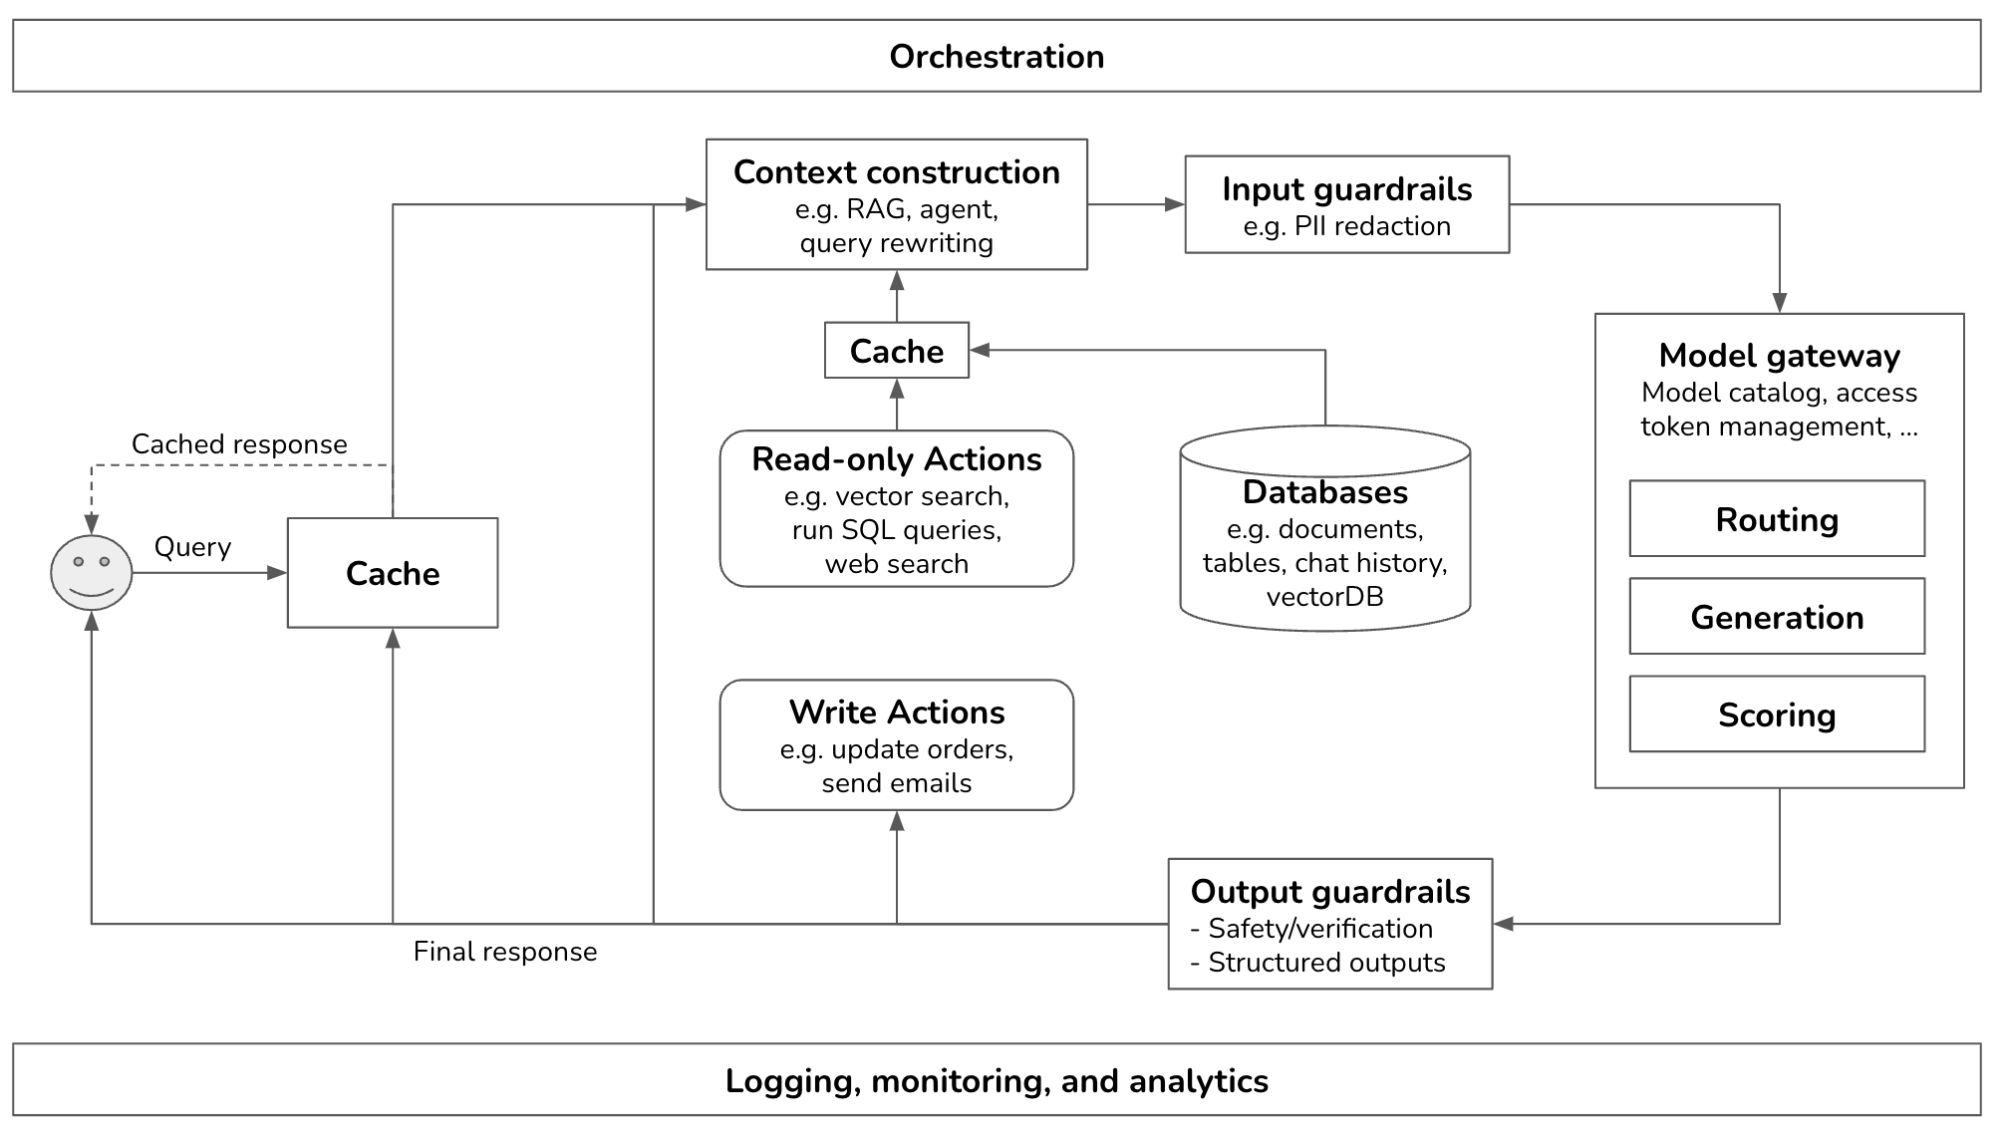

# Introduction to Retrieval-Augmented Generation (RAG)



RAG (Retrieval-Augmented Generation) is an AI framework that combines the strengths of traditional information retrieval systems (such as databases) with the capabilities of generative large language models (LLMs).  By combining this extra knowledge with its own language skills, the AI can write text that is more accurate, up-to-date, and relevant to your specific needs.

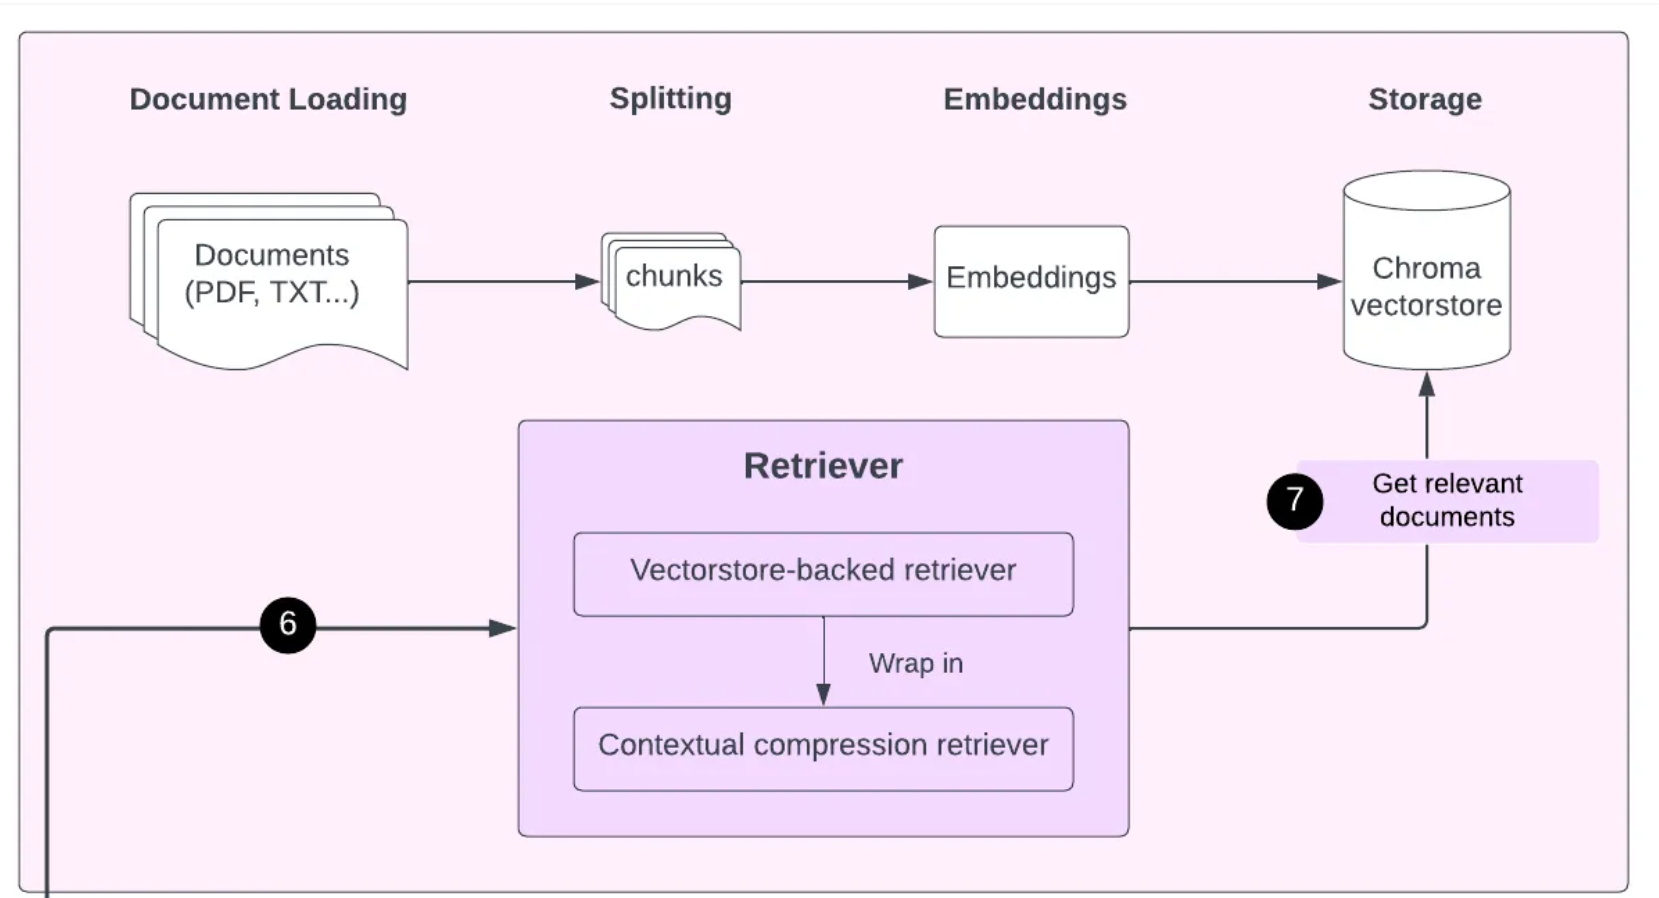


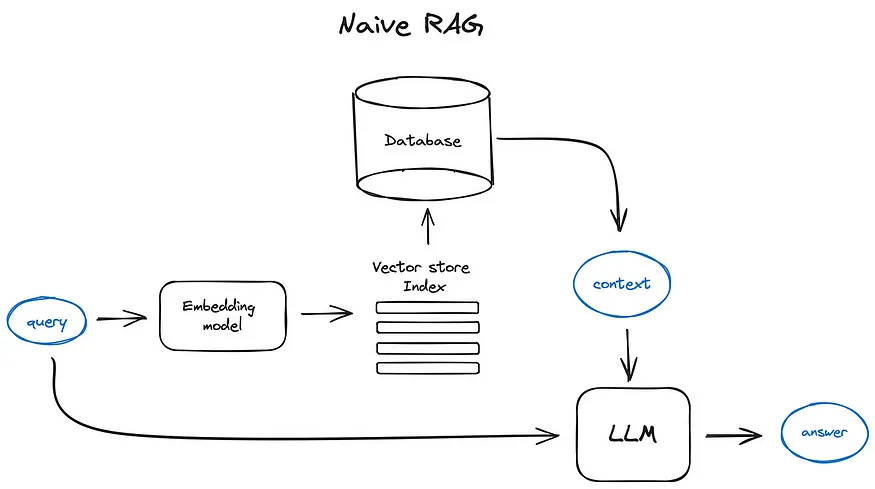

# Why Do We Need Retrieval-Augmented Generation (RAG)



Traditional language models, while powerful, often lack specific knowledge about niche or specialized topics.
1. Hallucination: The LLM may generate plausible-sounding but factually incorrect information.
2. Limited by Training Data: LLM Only knows what it saw during training.

RAG addresses this issue by augmenting the generative process with retrieved documents, ensuring the responses are both coherent and factually accurate.

# Let's dive in

### Setting Up the Environment

In [1]:
# # Install Packages We will use
! pip install langchain langchain_community langchain_chroma langchain-openai faiss-cpu pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 KB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 KB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 KB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 KB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### imports

In [3]:
# Import ChatOpenAI class for interacting with OpenAI's chat-based models
from langchain_openai import ChatOpenAI

# Import LLMChain for creating and managing chains of language models
from langchain.chains import LLMChain

# Import PromptTemplate for defining prompt templates used in language model interactions
from langchain_core.prompts import PromptTemplate

# Import PyPDFLoader for loading and processing PDF documents
from langchain_community.document_loaders import PyPDFLoader

# Import FAISS for vector-based search and retrieval
from langchain_community.vectorstores import FAISS

# Import OpenAIEmbeddings for generating embeddings using OpenAI models
from langchain_openai import OpenAIEmbeddings

# Import RecursiveCharacterTextSplitter for splitting text into smaller chunks for processing
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Import Chroma for handling and storing vector embeddings
from langchain_chroma import Chroma

import os


# https://python.langchain.com/v0.2/docs/how_to/document_loader_pdf/
# https://python.langchain.com/v0.2/docs/integrations/llms/openai/

### Load Env Vars

In [12]:
##
llm_name = os.environ["OPENAI_MODEL"]  # "gpt-4o-mini"
from dotenv import load_dotenv

load_dotenv()

True

## Results Before RAG

In [13]:
# Initialize the ChatOpenAI model with the specified model name
llm = ChatOpenAI(model=llm_name)

# Define a template for the prompt that includes a placeholder for the question
template = """Question: {question}
Answer: """

# Create a PromptTemplate instance using the defined template
prompt = PromptTemplate.from_template(template)

# Create an LLMChain instance with the language model and the prompt template
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Define a question to be asked to the language model
question = "What kind of recommendation did Usama use?"

# Invoke the LLMChain with the provided question and get the response
response = llm_chain.invoke(question)

# Print the text of the response
print("Answer: ", response["text"])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


Answer:  It seems you might be referring to a specific case or context involving someone named Usama and a type of recommendation they used. However, without additional details, it's difficult to provide a precise answer. Could you please provide more context or specify what you're asking about?


# Let's use Enhance the LLMs knowledge

In [14]:
file_path = "italy_book.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages[0]

Document(metadata={'source': 'italy_book.pdf', 'page': 0}, page_content='ITALY\n Unconventional Travel Guides')

In [15]:
# Initialize the RecursiveCharacterTextSplitter with a specified chunk size and overlap
# chunk_size: maximum number of characters per chunk
# chunk_overlap: number of characters to overlap between chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split the provided documents (pages) into smaller chunks using the text splitter
splits = text_splitter.split_documents(pages)

# Create a Chroma vectorstore from the split documents
# Chroma handles the storage and retrieval of vector embeddings
# OpenAIEmbeddings are used to generate embeddings for the documents
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Convert the Chroma vectorstore into a retriever that can be used for querying
retriever = vectorstore.as_retriever()



## Retrieval Component

In [70]:
# Create a FAISS index from the provided documents using OpenAI embeddings
faiss_index = FAISS.from_documents(splits, OpenAIEmbeddings())
question = "Where to party in Rome?"

# Perform a similarity search in the FAISS index for documents related to the query "Recommendation"
# Retrieve the top 2 most similar documents along with their similarity scores
embedding_vector = OpenAIEmbeddings().embed_query(question)
sources = faiss_index.similarity_search_by_vector(embedding_vector)
# docs_with_scores = faiss_index.similarity_search_with_score(question)

# Iterate through the retrieved documents and their similarity scores
# for doc, score in docs_with_scores:
#     # Print the page number, a snippet of the document content, and the similarity score
#     print((doc.metadata["page"], doc.page_content, score))


page_content='a certain kind of Roman man.   If you’re a little older and/or you’re interested in actual conversation, the best places are the many bars and squares in the Trastevere neighborhood, where the locals tend to congregate outside instead of huddling around tables indoors with their backs to you. Apart from that, any event that is outdoors and crowded will be better than sitting in a restaurant' metadata={'source': 'italy_book.pdf', 'page': 215}


'37\t\r \xa0 Plan your trip based on where you want to go. \nPLAN BY PLACE'

## Augmenting with Retrieved Data

In [71]:
# Create a combined prompt with retrieved documents
# combined_prompt = template.format(question=question)

template = f"\n Only using the following documents and cite the resource at the end: "
for source in sources:
    template += "\n"+source.page_content.strip()
template += """Question: {Question}
Answer: """
# for doc, _ in docs_with_scores:
    # print(doc.page_content +"\n")
    # template += "\n" + doc.page_content
combined_prompt = PromptTemplate.from_template(template)

# Create LLM chain
llm_chain = LLMChain(llm=llm, prompt=combined_prompt)
combined_prompt

PromptTemplate(input_variables=['Question'], template='\n Only using the following documents and cite the resource at the end: \na certain kind of Roman man.   If you’re a little older and/or you’re interested in actual conversation, the best places are the many bars and squares in the Trastevere neighborhood, where the locals tend to congregate outside instead of huddling around tables indoors with their backs to you. Apart from that, any event that is outdoors and crowded will be better than sitting in a restaurant\nand beer. This gives them the chance to look at each other, which is good, because everyone there is gorgeous. There are always a lot of locals.  Gusto (www.gusto.it), along the river, not far from Piazza di Spagna, has one of the best aperitivi in town. For 10 euros, you can get a fun cocktail (I get the Mediterranean Mojito with cherry tomatoes) and as many trips as you want to the very solid appetizer buffet.   The rooftop bar of the Hotel Eden (address: Via Ludovisi 4

## Enhanced Responses

In [72]:
response = llm_chain.invoke(question)
print(response["text"])

To party in Rome, you should head to the Trastevere neighborhood, which is known for its lively atmosphere and numerous bars where locals gather. This area is ideal for actual conversation, as people tend to congregate outside rather than sitting indoors. Additionally, outdoor events that are crowded, such as soccer games or concerts in piazzas, also provide a great social atmosphere. For a more upscale experience, consider visiting the rooftop bar of the Hotel Eden for stunning sunset views, although it is on the pricier side. Lastly, Gusto offers a great aperitivo experience with a solid appetizer buffet, making it a fun place to socialize. 

(Source: Unspecified document)


###

# Advanced Topics

1- changing Data sources (APIs)

2- Exact wording (Customer support use case)

- parent -> child retrieval

3- Reranking:

- newer knowledge

- other metadata (location,etc)    